- title: tutorial: Creating a simple GUI with Tkinter
- date: 2020-08-25 12:00
- category: tutorial
- tags: python, application
- slug: honorary_2
- authors: Julien Hernandez Lallement
- summary: A simple GUI to help people interact with your code
- illustration: 2020_08_honoraire.jpg

In the previous post, I created a function, based on a business day calendar, to calculate fees that should be paid to a expert translator for hours worked during day or night, on business or weekend/holidays. 

Here, I wrote a small script to put all of that in the form of a GUI using Tkinter. This was new to me, so I followed tutorials, including [this](https://www.youtube.com/watch?v=YXPyB4XeYLA) very nice one I can recommend if you know nothing about Tkinter.

Let's get started!

First, I am going to copy paste the function I wrote in the previous post

In [2]:
import pandas as pd
from pandas.tseries.holiday import *
from pandas.tseries.offsets import CustomBusinessDay

class FrenchBusinessCalendar(AbstractHolidayCalendar):
   rules = [
        Holiday('New Years Day', month=1, day=1),
        EasterMonday,
        Holiday('Labour Day', month=5, day=1),
        Holiday('Victory in Europe Day', month=5, day=8),
        Holiday('Ascension Day', month=1, day=1, offset=[Easter(), Day(39)]),
        Holiday('Bastille Day', month=7, day=14),
        Holiday('Assumption of Mary to Heaven', month=8, day=15),
        Holiday('All Saints Day', month=11, day=1),
        Holiday('Armistice Day', month=11, day=11),
        Holiday('Christmas Day', month=12, day=25)
   ]

French_BD = CustomBusinessDay(calendar=FrenchBusinessCalendar())
s = pd.date_range('2016-12-29', end='2021-01-03', freq=French_BD)
df = pd.DataFrame(s, columns=['Date'])

# Define fares depending on day time
normal_dict = {'day_first_hour_fare':'40',
           'night_first_hour_fare':'49.50',
           'day_subsequent_hour_fare': '32',
           'night_subsequent_hour_fare': '37.50'
          }

holiday_dict = {'day_first_hour_fare':'49.50',
                'night_first_hour_fare':'57',
                'day_subsequent_hour_fare':'37.50',
                'night_subsequent_hour_fare':'45'

}


I modified a bit the function, so that the ouput would not be the actual amount in euros needed to be paid, but a string displaying different information:

In [3]:
def calculate_honorary(start_date, end_date, normal_dict, holiday_dict):
    """
    Calculate the honorary for worked hours based on following rules

    params: start_date (str), start date in format '%Y-%m-%d-H:M:S'
    params: end_date (str), end date in format '%Y-%m-%d-H:M:S'
    params: normal_dict (dict), business day fare dictionnary
    params: holiday_dict (dict), holiday day fare dictionnary

    #### Payment Rules

    day is between 0700 and 2200
    night is between 2200 and 0700

    normal day fare:
     * first hour = 40 euros
     * subsequent hour = 32 euros

    normal night fare
     * first hour = 49.50 euros
     * subsequent hour = 37.50 euros

    holiday fare:
     * first hour = 49.50 euros
     * subsequent hour = 37.50 euros

    holiday fare
     * first hour = 57 euros
     * subsequent hour = 45 euros
    """

    # Transform dates to Timestamps
    start_date = pd.Timestamp(start_date)
    end_date = pd.Timestamp(end_date)

    print('Start date: ' + str(start_date))
    print('End date: ' + str(end_date))
    print(' ')
    # Get number of hours worked
    number_hours_worked = int(pd.Timedelta(end_date - start_date, unit='h') / timedelta(hours=1))
    if number_hours_worked < 0:
        raise ValueError("End date happened before start date")
    else:
        main_mess = 'You have worked ' + str(number_hours_worked) + ' hours.'
        print(main_mess)

    # Get actual hours relative to the day
    worked_hours = pd.Series(pd.date_range(start_date, end_date, freq='H').hour)

    # Get whether these hours were day or night shift
    bins = [0, 7, 22]  # Day is defined between 0700 and 2200
    labels = ['Night', 'Day']
    shift = pd.cut(worked_hours, bins=bins, labels=labels, include_lowest=True).replace('Night1', 'Night')
    hours_per_shift = pd.DataFrame(pd.concat([worked_hours, shift], axis=1)).groupby(1).count()
    print(hours_per_shift)

    # Verify whether start date is holiday
    if (df.Date.astype(str).str.contains(start_date.strftime('%Y-%m-%d')).sum()) > 0:
        # Day in calendar, so not holiday
        start_holiday = False
        fare_dict = normal_dict
        start_date_mess = 'Start date is business day.'
        print(start_date_mess)
    else:
        # Day not in calendar, so holiday
        start_holiday = True
        fare_dict = holiday_dict
        start_date_mess = 'Start date is weekend or holiday'
        print(start_date_mess)
    if df.Date.astype(str).str.contains(end_date.strftime('%Y-%m-%d')).sum() > 0:
        # Day in calendar, so not holiday
        end_holiday = False
        fare_dict = normal_dict
        end_date_mess = 'End date is business day'
        print(end_date_mess)
    else:
        # Day not in calendar, so holiday
        end_holiday = True
        fare_dict = holiday_dict
        end_date_mess = 'End date is weekend or holiday'
        print(end_date_mess)

    honorary_night = ((hours_per_shift.T.Night.values - 1) * float(normal_dict.get("night_subsequent_hour_fare"))
                      + float(normal_dict.get("night_first_hour_fare"))
                      )

    honorary_day = ((hours_per_shift.T.Day.values - 1) * int(normal_dict.get("day_subsequent_hour_fare"))
                    + int(normal_dict.get("day_first_hour_fare"))
                    )

    honorary_total = int(honorary_day + honorary_night)

    print(' ')
    honorary_mess = 'You are owed ' + str(honorary_total) + ' euros.'
    print(honorary_mess)

    return ('Start date: ' + str(start_date) + '          '
           + 'End date: ' + str(end_date) + '          '
           +  start_date_mess + '               '
           + end_date_mess+ '                   '
           + main_mess + '                    '
           + honorary_mess)

Now, I can wrap this function in a GUI using Tkinter

First, import the necessary packages:

In [ ]:
from tkinter import *
from tkcalendar import *
from tkinter import messagebox

We then start the Tkinter instance by calling `Tk()`, and giving it a title

In [7]:
root = Tk()
root.title("Honorary Calculator")

''

Now, what I need is for the user to enter both a start and end date of mission, as well as a start and end hour of mission.
To do so, I am using the Tkcalendar package (you will need to install it via pip), which provides a nice date picker GUI, see `Calendar` instance below

I provide a date picker for the date, and a simple entry box for the hours of begin and end of mission, using the `Entry` instance below.

In [ ]:
# Create Calendar instance for the start date
# Y, M & D just indicates the standard date to be showed when opening the calendar instance
cal_start_date = Calendar(root, selectmode="day",year=2020, month=6, day=1)

# Create a frame around the Entry box for mission start hour
frame_start_hour = LabelFrame(root, text='Start Hour(H:M:S)',padx=10,pady=10)
frame_start_hour.grid(row=0,column=0,padx=10,pady=10)
# Create an Entry Box in that frame
e_start_hour = Entry(frame_start_hour,width=35,bg="black", fg='white', borderwidth=5)

# Calendar for End Date
cal_end_date = Calendar(root, selectmode="day",year=2020, month=6, day=1)
cal_end_date.grid(row=1,column=1#padx=10,pady=10)
# Box for end hour
frame_end_hour = LabelFrame(root, text='End Hour (H:M:S)',padx=10,pady=10)
# Entry for end hour
e_end_hour = Entry(frame_end_hour,width=35,bg="black", fg='white', borderwidth=5)

That's it! Tkinter is really easy to use and intuitive, so you can get to quite nice results very fast. 

Now, let's mount all of that on the GUI window by defining different rows and columns

In [ ]:
# Mount on GUI window
cal_start_date.grid(row=1,column=0,padx=10,pady=10)
e_start_hour.grid(row=1,column=0)
                  
frame_end_hour.grid(row=0,column=1,padx=10,pady=10)
e_end_hour.grid(row=1,column=1)

In [ ]:
If you now run this code, you will see the following GUI:
    

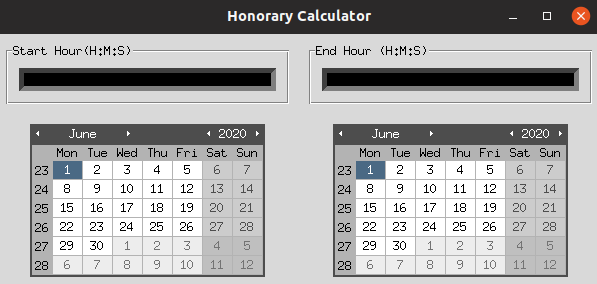

In [12]:
from IPython.display import Image
PATH = "/home/julien/website/content/images/2020_08_tkinter/"
Image(filename = PATH + "screenshot_1.png", width=1000, height=1200)

Now, we need to create a interaction, so that pushing a button (that we define later) really does the fee calculation coded in the function.

Since this GUI was coded for my mom, I really need a very easy, not fancy, interface that displays the message once the button is pressed.

Hence, I decided to go for the `showinfo` messagebox, that will display the results in a info window (btw, this is the reason why I changed the output of the function to a series of string).

In [ ]:
def popup():
    messagebox.showinfo('Honorary Results', calculate_honorary(start_date=str(cal_start_date.get_date()) + ' '+ str(e_start_hour.get()),
                                                                                                       end_date=str(cal_end_date.get_date()) + ' ' + str(e_end_hour.get()),
                                                                                                       normal_dict=normal_dict,
                                                                                                       holiday_dict=holiday_dict)
                        )

I now add a few buttons so that the user can interact with the GUI.

Note that the `command` parameter is given the `popup` function, which in terms enables the user to use the function we defined previously to calculate the fees.

I also add a Quit button, just because I can ;)

In [ ]:
# Define Buttons

button_confirm = Button(root, text="Calculate!", padx=40, pady=20, command=popup)


# Put the buttons on screen

button_confirm.grid(row=2, column=0, columnspan=3)

button_quit = Button(root, text = 'Exit Calculator', command=root.quit)
button_quit.grid(row=3, column=0, columnspan=3)

You would then be seeing something like this:

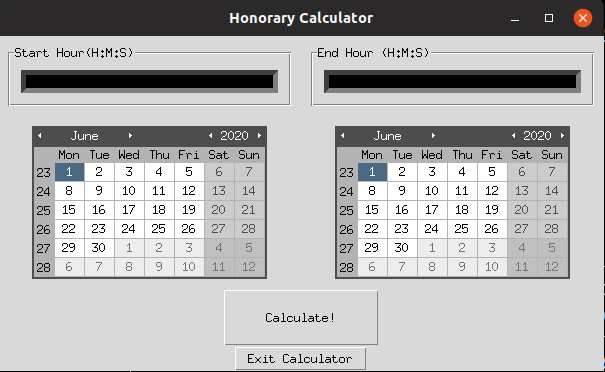

In [14]:
Image(filename = PATH + "screenshot1.png", width=1000, height=1200)

Note that for the GUI to work, you need to add the classic `root.mainloop()`

In [ ]:
root.mainloop()

That's it! You have a functional GUI that allows users to run the code by providing the date and hour input, which will return the amount in euros that need to be paid for the service.

You could make that much fancier, and add more functionnalities, but that's where I'll stop for now.

I should not that running this code separatly in notebook is not going to produce the GUI. You would have to pack the code in one or multiple .py files, and run them from the prompt, preceded by `python`. 

You can find this .py files, together with a few other examples of Tkinter in my repository https://github.com/juls-dotcom/honorary_calculator

Cheers!